In [1]:
import numpy as np
import sys
sys.path.append('./../src/')
from SDE_solver import solve_sde_RK
from utils import plot_trajectories_2
import matplotlib.pyplot as plt
from MLE_drift import *
import torch

from celluloid import Camera
from IPython.display import HTML
import math


Bad key "text.kerning_factor" on line 4 in
/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Double well

In [ ]:
feature_x = np.arange(-1.5, 1.5, 0.1)
feature_y = np.arange(-1.5, 1.5, 0.1)
x, y = np.meshgrid(feature_x, feature_y)
z = (5/2.0)*(x**2-1)**2+y**2



h = plt.contourf(feature_x,feature_y,z)
plt.show()



In [ ]:
u = -(10*x*(x**2-1))
v = -(2*y)

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.1
v = (v / norm)*0.1

fig, ax = plt.subplots(1, 1)

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [ ]:
deriv_x = lambda x: -(10*x*(x**2-1))
deriv_y = lambda y: -(2*y)

prior_drift = lambda X: torch.tensor([[deriv_x(i[0]),deriv_y(i[1])] for i in X])

In [ ]:
num_samples=5
sigma = 0.5
dt = 0.05
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))


t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=torch.cat((X_0,X_1)), dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

In [ ]:
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')



In [ ]:
result = MLE_IPFP(X_0,X_1,N=N,sigma=0.5)

In [ ]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
#animation.save('animation.mp4')

# Triple well

In [2]:
feature_x = np.arange(-1.5, 1.5, 0.05)
feature_y = np.arange(-1, 2, 0.05)
x, y = np.meshgrid(feature_x, feature_y)
z = 3*np.exp(-x**2 - (y-(1.0/3)) **2) - 3*np.exp( -x**2 - (y-(5.0/3))**2) - 5 * np.exp( -(x-1)**2-y**2) - 5*np.exp(-(x+1)**2-y**2 ) + 0.2*x**4 + 0.2*(y-(1.0/3))**4

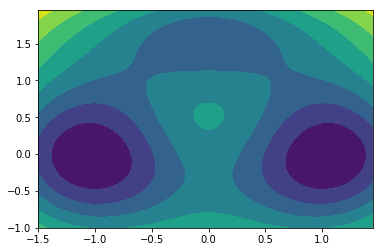

In [3]:
h = plt.contourf(feature_x,feature_y,z)
plt.show()


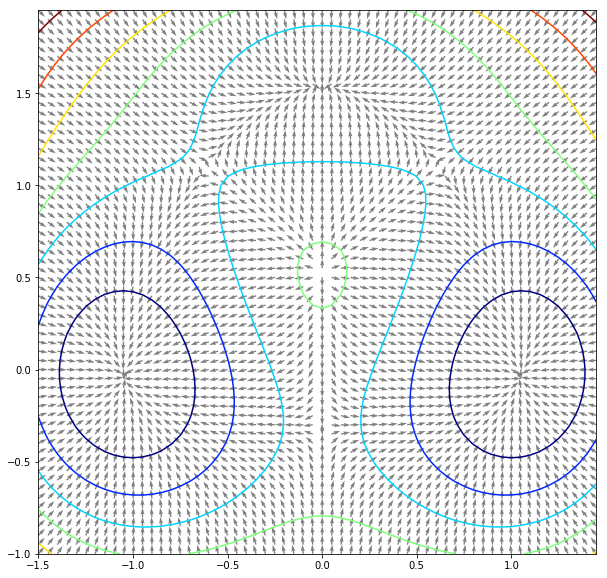

In [31]:
u = -(0.8*x**3 + 6*x*np.exp(-x**2-(y-(5.0/3))**2) - 6*x*np.exp( -x**2 - (y-(1.0/3))**2) + 10*(x-1)*np.exp(-(x-1)**2 - y**2 ) + 10*(x+1)*np.exp(-(x+1)**2 - y**2))
v = -(-6*(y-(1.0/3)) * np.exp( -x**2 - (y-(1.0/3))**2)+6*(y-(5.0/3)) * np.exp( -x**2 - (y-(5.0/3))**2) + 10*y*np.exp(-(x-1)**2-y**2)+ 10*y*np.exp(-(x+1)**2-y**2) + 0.8*(y-(1.0/3))**3)

norm = np.linalg.norm(np.array((u, v)), axis=0)
u = (u / norm)*0.05
v = (v / norm)*0.05

fig, ax = plt.subplots(1, 1,figsize=(10,10))

ax.quiver(x, y, u, v, units='xy', scale=1, color='gray')
ax.contour(x, y, z, 7, cmap='jet')


In [5]:
deriv_x = lambda x,y: -(0.8*x**3 + 6*x*np.exp(-x**2-(y-(5.0/3))**2) - 6*x*np.exp( -x**2 - (y-(1.0/3))**2) + 10*(x-1)*np.exp(-(x-1)**2 - y**2 ) + 10*(x+1)*np.exp(-(x+1)**2 - y**2))
deriv_y = lambda x,y: -(-6*(y-(1.0/3)) * np.exp( -x**2 - (y-(1.0/3))**2)+6*(y-(5.0/3)) * np.exp( -x**2 - (y-(5.0/3))**2) + 10*y*np.exp(-(x-1)**2-y**2)+ 10*y*np.exp(-(x+1)**2-y**2) + 0.8*(y-(1.0/3))**3)

In [6]:
prior_drift = lambda X: torch.tensor([[deriv_x(i[0],i[1]),deriv_y(i[0],i[1])] for i in X])

In [27]:
num_samples=5
sigma = 0.5
dt = 0.05
N = int(math.ceil(1.0/dt))
mu_0 = torch.tensor([1.0,0.0])
X_0 = torch.distributions.multivariate_normal.MultivariateNormal(mu_0,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))
mu_1 = torch.tensor([-1.0,0.0])
X_1 = torch.distributions.multivariate_normal.MultivariateNormal(mu_1,torch.eye(2)*0.05).sample((num_samples,1)).reshape((-1,2))


t, Xts = solve_sde_RK(b_drift=prior_drift,sigma=sigma, X0=torch.cat((X_0,X_1)), dt=dt, N=N)
#plot_trajectories_2(Xts, t, remove_time=True)

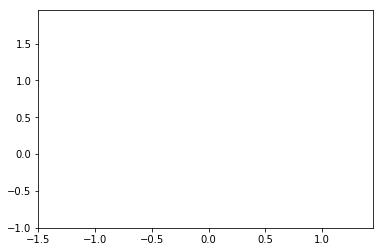

In [28]:
fig = plt.figure()
camera = Camera(fig)
for i in range(N):    
    plt.contourf(feature_x,feature_y,z)
    plt.scatter(Xts[:,i,0].detach(),Xts[:,i,1].detach())
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())

In [29]:
result = MLE_IPFP(X_0,X_1,N=N,sigma=0.5)

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


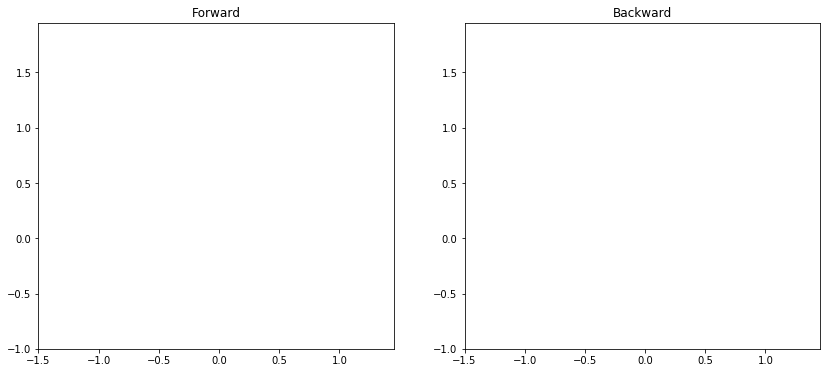

In [30]:


fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
camera = Camera(fig)
M = result[-1][1]
M2 = result[-1][3]
for i in range(N):    
    ax1.contourf(feature_x,feature_y,z)
    ax2.contourf(feature_x,feature_y,z)
    ax1.scatter(M[:,i,0].detach(),M[:,i,1].detach())
    ax2.scatter(M2[:,i,0].detach(),M2[:,i,1].detach())
    ax1.set_title("Forward")
    ax2.set_title("Backward")
    
    ax1.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax2.text(0.9, 0, r'$X_0$', fontsize=20,color='red')
    ax1.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')
    ax2.text(-1.1, 0, r'$X_1$', fontsize=20,color='red')

    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())